In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [37]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd

In [39]:
np.random.seed(0)

In [40]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"

<class 'dict'>
(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [41]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

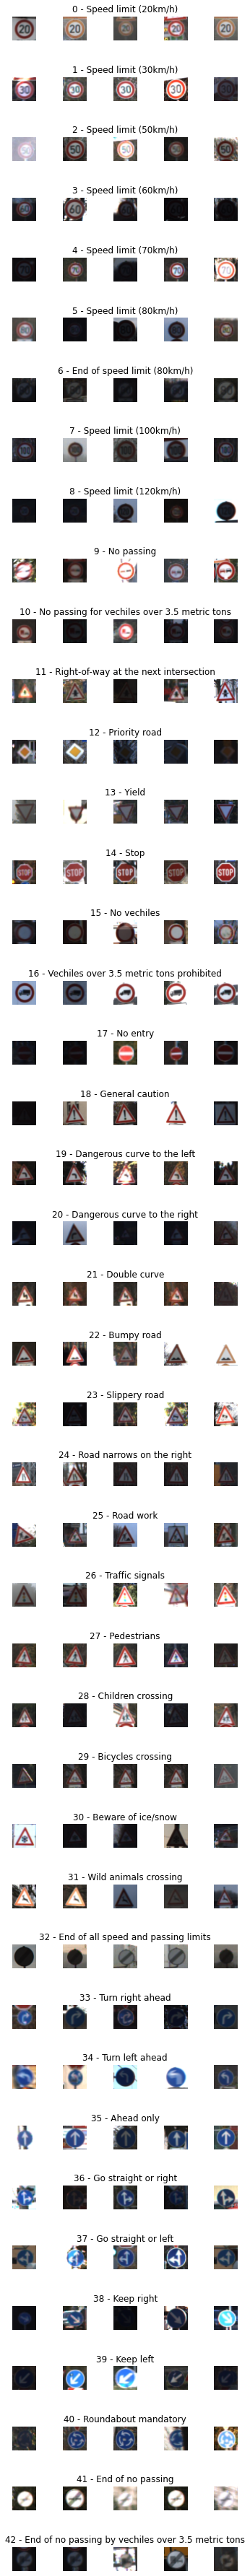

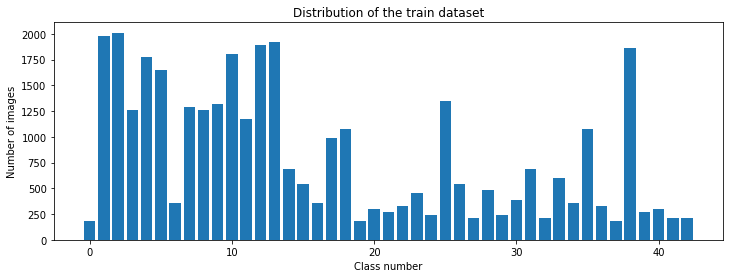

In [42]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[np.random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
Label of the sign:  36


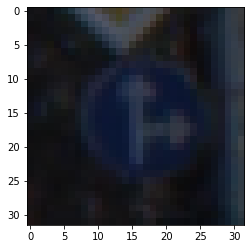

In [43]:
import cv2

plt.imshow(X_train[1000])
print(X_train[1000].shape)
print('Label of the sign: ', y_train[1000])

(32, 32)


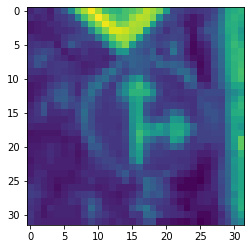

In [44]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  return img

gray = grayscale(X_train[1000])
plt.imshow(gray)
print(gray.shape)

(32, 32)


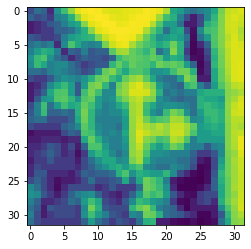

In [45]:
def equalize(img):  # img must be grayscale
  img = cv2.equalizeHist(img)
  return img

img = equalize(gray)
plt.imshow(img)
print(img.shape)

In [46]:
def preprocess(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

In [47]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [48]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  #Compile model
  model.compile(Adam(lr = 0.1), loss = "categorical_crossentropy", metrics = ['accuracy'])
  return model

In [49]:
model = leNet_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               270500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)              

In [50]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_val, y_val), batch_size= 400, verbose=1, shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 26s 740us/step - loss: 4.7367 - accuracy: 0.0552 - val_loss: 3.5603 - val_accuracy: 0.0544
Epoch 2/10
34799/34799 [==============================] - 26s 737us/step - loss: 3.4835 - accuracy: 0.0559 - val_loss: 3.5598 - val_accuracy: 0.0544
Epoch 3/10
34799/34799 [==============================] - 26s 737us/step - loss: 3.4833 - accuracy: 0.0572 - val_loss: 3.5643 - val_accuracy: 0.0544
Epoch 4/10
34799/34799 [==============================] - 26s 737us/step - loss: 3.4832 - accuracy: 0.0576 - val_loss: 3.5625 - val_accuracy: 0.0476
Epoch 5/10
34799/34799 [==============================] - 26s 739us/step - loss: 3.4836 - accuracy: 0.0558 - val_loss: 3.5643 - val_accuracy: 0.0476
Epoch 6/10
34799/34799 [==============================] - 26s 741us/step - loss: 3.4844 - accuracy: 0.0545 - val_loss: 3.5597 - val_accuracy: 0.0544
Epoch 7/10
34799/34799 [==============================] -

Text(0.5, 0, 'epoch')

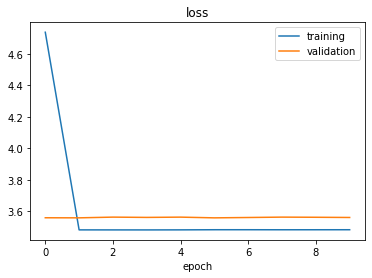

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

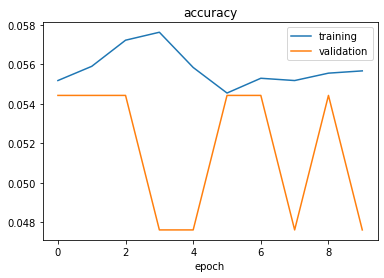

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [56]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Test score:  3.470639817863821
Test accuracy:  0.05225653201341629
